# Imports and definitions

In [1]:
local_mode = True

from collections import Counter, defaultdict
import itertools
import math
import os
import random
import re
import sys

if local_mode:
    sys.path.append("/Users/mfa/git")
else:
    sys.path.append("/home/ma629/git")

from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import beta, wilcoxon, mannwhitneyu, pearsonr, spearmanr, ttest_rel, ttest_ind, kruskal
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from ariadne import ariadne, plots, daedalus, terms
from rouls.seq_utils import read_fasta
from rouls.struct_utils import predict_structure, read_ct_file_single
from rouls.dreem_utils import get_clusters_mu_filename, get_sample_and_run, read_clusters_mu, mu_histogram_paired, plot_data_structure_roc_curve, get_data_structure_agreement

In [2]:
# Define parameters and global variables

plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

if local_mode:
    analysis_dir = "/Users/mfa/o2m/rna_np_210422Rou/Analysis"
    #analysis_dir = "/Users/mfa/o2l/projects/matty/rna_np_210422Rou/Analysis"
else:
    analysis_dir = "/n/data1/hms/microbiology/rouskin/lab/projects/matty/rna_np_210422Rou/Analysis"

proj_dir = os.path.dirname(analysis_dir)
em_dir = "EM_Clustering"

dms_bases = ["A", "C"]
n_rre_clusters = 2

rre_ref_structs_name_to_dot = {
        "5-stem": ".((((((((.((((((((..(((((((((...))))))).))........((((((.....)))))).))))))))..(((((((....)))))))........((((..(((((((...)))))))..))))..(((((((((........))))))))).....)))).))))",
        "4-stem": ".((((((((.((((((((..(((((((((...))))))).))........((((((.....)))))).)))))))).((((((((......(((((...(((.....)))....)))))))))))))........(((((((((........))))))))).....)))).))))",
}

rre_ref_structs_dot_to_name = {dot: name for name, dot in rre_ref_structs_name_to_dot.items()}

rre_k_cluster_names = {1: ["5-stem"], 2: ["5-stem", "4-stem"]}

sample_clustering_runs = {("rO66v2", 2): 10}

amplicons = {
    "RRE": [(28, 202)],
    "23S": [(25, 463), (427, 871), (825, 1287), (1222, 1671), (1594, 1958)],
    "M13": [(31, 526), (525, 1033)],
    "EGFP": [(24, 473), (315, 765)],
    "rsc1218v1n660": [(29, 471), (436, 629)],
    "rsc1218v1n924": [(29, 471), (436, 892)],
}

rT66v2_stap10_target = list(range(259, 278 + 1)) + list(range(497, 520 + 1))

exclude_samples = ["rO44v2"]

In [3]:
def clean_outputs():
    # Remove existing plots and tabular outputs to start fresh.
    for ext in ["pdf", "tsv"]:
        os.system(f"rm {proj_dir}/Analysis/*{ext}")
        

def tidy_feature(feature):
    return feature.split("_")[1].strip("035")


def geo_mean(x, ignore_nan=True):
    if np.any(np.asarray(x) < 0.0):
        return np.nan
    if np.any(np.isclose(x, 0.0)):
        return 0.0
    if ignore_nan:
        mean = np.nanmean
    else:
        mean = np.mean
    return np.exp(mean(np.log(x)))
    

def read_sample_data():
    sample_file = os.path.join(proj_dir, "samples.txt")
    sample_data = pd.read_csv(sample_file, sep="\t", index_col="Sample")
    sample_data = sample_data.loc[~sample_data.index.isin(exclude_samples)]
    return sample_data


def num_to_id(num):
    sample_id = f"210422Rou_D21-{num}"
    return sample_id


def get_fasta_full_name(fasta_file, project_dir=proj_dir):
    if not fasta_file.endswith(".fasta"):
        fasta_file = fasta_file + ".fasta"
    ref_genome_dir = os.path.join(project_dir, "Ref_Genome")
    fasta_file = os.path.join(ref_genome_dir, fasta_file)
    return fasta_file


def get_dot_file_full_name(proj_dir, em_dir, sample, ref, start, end, k, c, run=None, **kwargs):
    if run is None:
        run = "best"
    run_dir = get_sample_and_run(os.path.join(proj_dir, em_dir), k, sample, ref, start, end, run=run)
    prefix = run_dir.split(os.sep)[-3]
    dot_file = os.path.join(run_dir, f"{prefix}-K{k}_Cluster{c}_expUp_0_expDown_0_pk.dot")
    return dot_file


def read_dot_file(dot_file):
    with open(dot_file) as f:
        name, seq, structure = [f.readline().strip() for i in range(3)]
    return name, seq, structure


def get_sample_mus(sample_data, sample_name):
    # Get the IDs of the samples containing the origami and the RRE.
    origami_num = sample_data.loc[sample_name, "Origami"]
    origami_id = num_to_id(origami_num)
    rre_num = sample_data.loc[sample_name, "RRE"]
    rre_id = num_to_id(rre_num)
    # Read the sequence of the origami scaffold.
    scaf_name = sample_data.loc[sample_name, "Scaffold"]
    scaf_seq_file = get_fasta_full_name(scaf_name)
    _, scaf_seq = read_fasta(scaf_seq_file)
    # Read the sequence of the RRE.
    rre_seq_file = get_fasta_full_name("RRE")
    _, rre_seq = read_fasta(rre_seq_file)
    # Read mutation rates of RRE.
    ref = "RRE"
    em_dir = "EM_Clustering"
    start, end = amplicons[ref][0]
    rre_mus = dict()
    for k in range(1, n_rre_clusters + 1):
        run = sample_clustering_runs.get((sample_name, k), "best")
        structure_order = list()
        for c in range(1, k + 1):
            dot_file = get_dot_file_full_name(proj_dir, em_dir, rre_id, ref, start, end, k, c, run=run)
            name, seq, structure = read_dot_file(dot_file)
            structure_name = rre_ref_structs_dot_to_name[structure]
            structure_order.append(structure_name)
        rre_mus_file = get_clusters_mu_filename(em_clustering_dir=os.path.join(proj_dir, em_dir), k=k, sample=rre_id, ref=ref, start=start, end=end, run=run)
        rre_mus[k] = read_clusters_mu(rre_mus_file, flatten=False, seq=rre_seq, include_gu=False)
        rre_mus[k].columns = structure_order
    # Read mutation rates of origami.
    k = 1
    origami_mus = pd.Series(dtype=np.float64)
    for amplicon in amplicons[scaf_name]:
        start, end = amplicon
        mus_file = get_clusters_mu_filename(em_clustering_dir=os.path.join(proj_dir, em_dir), k=k, sample=origami_id, ref=scaf_name, start=start, end=end, run="best")
        amplicon_mus = read_clusters_mu(mus_file, flatten=True, seq=scaf_seq, include_gu=False)
        # Average signal in overlaps between amplicons.
        if len(origami_mus) > 0:
            overlap = sorted(set(origami_mus.index) & set(amplicon_mus.index))
            if len(overlap) > 0:
                overlap_prev = origami_mus.loc[overlap]
                overlap_amp = amplicon_mus.loc[overlap]
                corr_amp_prev = np.corrcoef(overlap_amp, overlap_prev)[0,1]
                # Double check that the correlation is high, i.e. above 0.9
                corr_min = 0.9
                assert corr_amp_prev >= corr_min
                # If the correlation is high, average the two, as is common practice for replicates.
                consensus = (overlap_prev + overlap_amp) / 2
                origami_mus.loc[overlap] = consensus
            # Add the new DMS signals.
            amplicon_new = amplicon_mus[sorted(set(amplicon_mus.index) - set(overlap))]
            origami_mus = pd.concat([origami_mus, amplicon_new])
        else:
            origami_mus = amplicon_mus
    return origami_mus, rre_mus


dms_col = "DMS_signal"


def calc_corrs_means_sliding(mus1, mus2, width):
    assert mus1.shape == mus2.shape
    assert np.all(mus1.index == mus2.index)
    idx_min = np.min(mus1.index)
    idx_max = np.max(mus1.index)
    windows = [(i, i + width - 1) for i in range(idx_min, idx_max - width + 2)]
    index = pd.MultiIndex.from_tuples(windows)
    index.names = ("first", "last")
    means1 = pd.Series([np.mean(mus1.loc[wi: wf]) for wi, wf in windows], index=index)
    means2 = pd.Series([np.mean(mus2.loc[wi: wf]) for wi, wf in windows], index=index)
    corrs = pd.Series([pearsonr(mus1.loc[wi: wf], mus2.loc[wi: wf])[0] for wi, wf in windows], index=index)
    return means1, means2, corrs


def plot_corr_signal_sliding(mus1, mus2, width, plot_file):
    aspect = 3.0
    means1, means2, corrs = calc_corrs_means_sliding(mus1, mus2, width)
    corrs.to_csv(f"{plot_file}_PCC.tsv", sep="\t")
    means1.to_csv(f"{plot_file}_DMS-1.tsv", sep="\t")
    means2.to_csv(f"{plot_file}_DMS-2.tsv", sep="\t")
    centers = np.asarray((corrs.index.get_level_values("first") + corrs.index.get_level_values("last")) // 2.0, dtype=int)
    fig, ax = plt.subplots()
    ax.plot(centers, corrs)
    ax.set_ylim((-1.0, 1.0))
    ax.set_aspect(len(centers) / 2.0 / aspect)
    ax.set_xlabel("Position")
    ax.set_ylabel("PCC")
    ax.set_title(plot_file)
    plt.savefig(f"{plot_file}_PCC.pdf")
    plt.close()
    for i, means in enumerate([means1, means2], start=1):
        fig, ax = plt.subplots()
        ax.plot(centers, means)
        ax.set_ylim((0.0, 0.1))
        ax.set_aspect(len(centers) / 0.1 / aspect)
        ax.set_xlabel("Position")
        ax.set_ylabel("DMS reactivity")
        ax.set_title(plot_file)
        plt.savefig(f"{plot_file}_DMS-{i}.pdf")
        plt.close()
        fig, ax = plt.subplots()
        ax.scatter(means, corrs)
        ax.set_xlim((0.0, 0.1))
        ax.set_ylim((-1.0, 1.0))
        ax.set_aspect(0.05)
        ax.set_xlabel("DMS reactivity")
        ax.set_ylabel("Correlation")
        ax.set_title(plot_file)
        plt.savefig(f"{plot_file}_DMS-PCC-{i}.pdf")
        plt.close()
    return centers, corrs


def winsor_norm(dataset, percentile):
    pct_val = np.percentile(dataset, percentile)
    if np.isclose(pct_val, 0.0):
        raise ValueError("Percentile is zero")
    if pct_val < 0.0:
        raise ValueError("Percentile is negative")
    winsorized = np.minimum(dataset / pct_val, 1.0)
    return winsorized


def validate_23S_mus(sample_mus):
    mus_23S = sample_mus["23S"]
    mus_23S.to_csv("23S_mus_normalized.tsv", sep="\t")
    mus_23S_simon = pd.read_excel("../Validation/Simon-et-al_23S.xlsx", index_col="Position")["Combined"]
    # Adjust index of our dataset to match that of Simon et al. (which uses the full 23S rRNA)
    offset = 29
    mus_23S = mus_23S.reindex(mus_23S_simon.index - offset, copy=True)
    mus_23S.index += offset
    # Drop any index with a missing value
    keep = np.logical_not(np.logical_or(np.isnan(mus_23S), np.isnan(mus_23S_simon)))
    mus_23S_keep = mus_23S.loc[keep]
    mus_23S_simon_keep = mus_23S_simon.loc[keep]
    # Apply 90% winsorization and normalization to mus_23S so it matches the processing in Simon et al.
    winsor_pct = 90.0
    mus_23S_keep = winsor_norm(mus_23S_keep, winsor_pct)
    # Compute correlation and scatterplot
    pearson_corr = pearsonr(mus_23S_keep, mus_23S_simon_keep)
    print("PCC:", pearson_corr)
    fig, ax = plt.subplots()
    ax.scatter(mus_23S_keep, mus_23S_simon_keep)
    ax.set_aspect(1.0)
    ax.set_xlabel("23S scaffold")
    ax.set_ylabel("23S in E. coli")
    plt.savefig("23S_mus_scatter.pdf")
    plt.close()
    na_val = -2.0
    diffs_23S = (mus_23S_keep.reindex(mus_23S_simon.index) - mus_23S_simon).fillna(na_val)
    diffs_23S.to_csv("23S_diffs.tsv", sep="\t", header=False)

feature_names = ["scafDX", "stapDX", "stapSX", "stapEND", "stapSXEND", "vertex"]
markers5 = {"scaf_scafDX_3": "x", "scaf_stapDX_3": "+", "scaf_stapSX_3": "1", "scaf_vertex_3": "*", "scaf_stapEND3_0": "o", "scaf_stapSXEND3_0": "D", "scaf_scafEND5_0": "s"}
colors3 = {"scaf_scafDX_5": "#5ab4e5", "scaf_stapDX_5": "#0a72ba", "scaf_stapSX_5": "#00a875", "scaf_vertex_5": "#da6fab", "scaf_stapEND5_0": "#f15a22", "scaf_stapSXEND5_0": "#f7941d", "scaf_scafEND3_0": "#aaaaaa"}
tidy_to_full = {
    "scafDX": "scaf_scafDX_5",
    "stapDX": "scaf_stapDX_5",
    "stapSX": "scaf_stapSX_5",
    "stapEND": "scaf_stapEND5_0",
    "stapSXEND": "scaf_stapSXEND5_0",
    "vertex": "scaf_vertex_5",
}

def get_markers(f5, f3):
    marker = markers5[f5]
    filled_marker = marker in "*oDs"
    if filled_marker:
        color = [(1.0, 1.0, 1.0, 0.0)]
        edgecolor = colors3[f3]
    else:
        color = colors3[f3]
        edgecolor = None
    return marker, color, edgecolor

def get_feature_hex(feature):
    if str(feature).lower() == "none":
        return "#dddddd"
    if feature in tidy_to_full:
        feature = tidy_to_full[feature]
    return colors3[feature]


def hex_to_rgb(hex):
    assert isinstance(hex, str)
    if hex.startswith("#"):
        hex = hex[1:]
    assert len(hex) == 6
    return tuple([int(hex[i: i+2], 16) for i in range(0, 4+1, 2)])


def get_feature_rgb(feature):
    return hex_to_rgb(get_feature_hex(feature))


tidy_colors = {feat: get_feature_hex(feat) for feat in ["none"] + feature_names}


jitter_std = 0.15
jitter_max = 0.30

# Analysis and figures

In [4]:
clean_outputs()


In [5]:
# Load the sample IDs.
sample_data = read_sample_data()

# Load the DMS mutation rates.
scaf_groups = dict()
sample_mus = dict()
rre_mus = dict()
for sample in sample_data.index:
    scaffold = sample_data.loc[sample, "Scaffold"]
    if scaffold not in scaf_groups:
        scaf_groups[scaffold] = list()
    scaf_groups[scaffold].append(sample)
    sample_mus[sample], rre_mus[sample] = get_sample_mus(sample_data, sample)
rre_mus = {(k, c): pd.DataFrame.from_dict({sample: mus[k][c] for sample, mus in rre_mus.items()}) for k in range(1, n_rre_clusters + 1) for c in rre_k_cluster_names[k]}

# Load the scaffold sequences.
scaf_seqs = dict()
for seq_name in sample_data["Scaffold"]:
    if seq_name not in scaf_seqs:
        _, scaf_seqs[seq_name] = read_fasta(get_fasta_full_name(seq_name))
scaf_seqs_df = {scaf: pd.Series(list(seq), index=range(1, len(seq) + 1)) for scaf, seq in scaf_seqs.items()}

# Compute the DMS signal ratios wrt 23S RRE.
rre_standard = "23S"
rre_means = rre_mus[1, "5-stem"].mean(axis=0)
sig_ratios = rre_means / rre_means[rre_standard]

# Normalize the DMS signals on the origami using the ratios.
sample_mus = {sample: mus / sig_ratios.loc[sample] for sample, mus in sample_mus.items()}
validate_23S_mus(sample_mus)
for k, c in rre_mus:
    # Compute the correlations over RRE controls.
    rre_corr = rre_mus[k, c].corr()
    rre_corr.to_csv("RRE_corr.txt", sep="\t")
    rre_mus[k, c] /= sig_ratios
    rre_mus[k, c].to_csv(f"rre_mus_{k}-{c}.tsv", sep="\t")

# Collect all DMS signals into one dataframe.
all_mus = pd.DataFrame([
        [
            sample_data.loc[sample, "Scaffold"],
            sample,
            idx,
            mu
        ]
        for sample, mus in sample_mus.items()
        for idx, mu in mus.items()
], columns=["Scaffold", "Sample", "Position", "DMS Signal"])
all_mus

PCC: (0.7763199819219238, 2.0833511288334697e-192)


,Scaffold,Sample,Position,DMS Signal
0,23S,rPB66v1,27,0.013063
1,23S,rPB66v1,28,0.003030
2,23S,rPB66v1,32,0.001391
3,23S,rPB66v1,34,0.010748
4,23S,rPB66v1,35,0.010471
...,...,...,...,...
8914,rsc1218v1n924,rsc1218v1n924,884,0.062029
8915,rsc1218v1n924,rsc1218v1n924,885,0.078555
8916,rsc1218v1n924,rsc1218v1n924,890,0.029477
8917,rsc1218v1n924,rsc1218v1n924,891,0.047714


<ipython-input-6-bc6fac8258df>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((0.0, np.max(all_mus["DMS Signal"]) * 1.05))


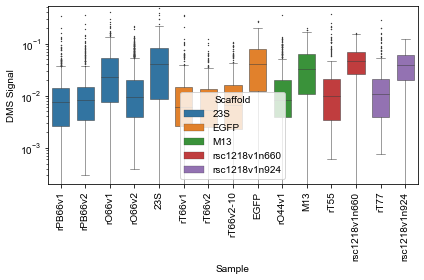

In [6]:
# Plot the DMS signals for all origamis.
sns.boxplot(data=all_mus, x="Sample", y="DMS Signal", hue="Scaffold", width=0.7, dodge=False, whis=2.0, linewidth=0.5, fliersize=0.5)
plt.yscale("log")
plt.ylim((0.0, np.max(all_mus["DMS Signal"]) * 1.05))
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("dms_signals_box.pdf")
#plt.close()

In [7]:
# Initialize data to collect from each origami.
origamis = dict()  # name of scaffold: names of origamis with that scaffold
scaffolds = dict()  # name of origami: name of scaffold
delta_mus_medians = dict()  # name of origami: median quotient of scaffold to origami DMS among all bases
delta_mus_p_values = dict()  # name of origami: p-value that its signal is different from scaffold (Wilcoxon signed rank test)
mus_medians_delta = dict()  # name of origami: quotient of median scaffold signal and median origami signal 
origamis_dir = os.path.join(proj_dir, "Origamis_singleXO")
scaf_chain = "A"
origami_analyze_features = ["rO66v1"]
base_info = dict()
origami_segments = dict()
feat_col = "Feature"

# Collect data from each origami.
for scaf, group in scaf_groups.items():
    group_df = pd.DataFrame.from_dict({x: sample_mus[x] for x in group})
    
    # Plot all the origamis in the group vs each other.
    print(group_df.corr()**2)
    sns.pairplot(group_df)
    plt.savefig(f"{scaf}_group.pdf")
    plt.close()
    group_df.to_csv(f"mus_{scaf}.tsv", sep="\t")
    
    # Predict structures for the scaffold.
    output_prefix = os.path.join(analysis_dir, f"{scaf}")
    seq = scaf_seqs[scaf]
    ct_file = f"{output_prefix}.ct"
    if not os.path.isfile(ct_file):
        predict_structure(scaf, seq, sample_mus[scaf], output_prefix,
                program="Fold", normbases=0.05, overwrite=True, queue=False)
    
    # Plot a histogram of the DMS signals.
    _, pairs, unpaired, seq_ct = read_ct_file_single(ct_file, multiple=0)
    assert seq_ct == seq
    hist_file = f"{output_prefix}_hist.pdf"
    mu_histogram_paired(hist_file, sample_mus[scaf], unpaired,
            bin_width=0.001)
    
    # Plot each origami vs its scaffold.
    origamis[scaf] = [x for x in group if x != scaf]
    for origami in origamis[scaf]:
        scaffolds[origami] = scaf
        print("Analyzing origami:", origami)
        
        # Plot DMS signals of each origami vs its scaffold. 
        fig, ax = plt.subplots()
        ax.scatter(sample_mus[origami], sample_mus[scaf], s=0.5)
        ax.set_aspect("equal")
        plt.xlim((0, 0.5))
        plt.ylim((0, 0.5))
        plt.xlabel(origami)
        plt.ylabel(scaf)
        plt.savefig(f"{scaf}_vs_{origami}_scatter.pdf")
        plt.close()
        fig, ax = plt.subplots()
        origami_boxplot_data = pd.DataFrame({scaf: sample_mus[scaf], origami: sample_mus[origami]})
        data_min = 1E-4
        origami_boxplot_data[origami_boxplot_data < data_min] = data_min
        flierprops = dict(marker='o', markerfacecolor="gray", markersize=2,
                          linestyle='none', markeredgecolor="gray")
        sns.boxplot(data=np.log10(origami_boxplot_data), flierprops=flierprops, linewidth=1.0)
        ax.set_ylim((data_min/2.0, 1E0))
        ax.set_aspect(1.5)
        #ax.set_yscale("log")
        ax.set_ylabel("DMS Reactivity")
        plt.savefig(f"{scaf}_vs_{origami}_box.pdf")
        plt.close()
        
        # Plot the correlation of the DMS signals in the origami vs. the scaffold as a sliding window.
        sliding_plot = f"{scaf}_vs_{origami}_sliding"
        sliding_width = 20
        scaf_corrs_centers, scaf_corrs = plot_corr_signal_sliding(sample_mus[scaf], sample_mus[origami], sliding_width, sliding_plot)
        
        # Compute the median change in DMS signal for the origami wrt the scaffold.
        delta_mus = sample_mus[scaf] / sample_mus[origami]
        delta_mus_medians[origami] = np.nanmedian(delta_mus)
        mus_medians_delta[origami] = np.median(sample_mus[scaf]) / np.median(sample_mus[origami])
        
        # Compute the significance of the difference using Wilcoxon signed-rank test.
        w_stat, p_value = wilcoxon(sample_mus[origami], sample_mus[scaf])
        delta_mus_p_values[origami] = p_value
        if origami not in origami_analyze_features:
            # Do not analyze the feature-DMS relationship.
            continue
        
        # Get the feature feature of each base in the origami.
        origami_dir = os.path.join(origamis_dir, sample_data.loc[origami, "Directory"])
        edges, g_up, g_dn, g_ax, base_info[origami], dssr_info = ariadne.analyze_design(origami_dir, compute_bond_lengths=False, clobber=True)
        
        # Remove staples, leaving only scaffold bases.
        base_info[origami] = base_info[origami].loc[base_info[origami].loc[:, "PDB chain"] == scaf_chain]
        
        # Get all the segments in the origami.
        segments = daedalus.get_segments(base_info[origami], g_up, g_dn)
        segments["Origami"] = origami
        segments["Length"] = segments["Seg3"] - segments["Seg5"] + 1
        assert np.all(segments["Length"] > 0)
        origami_segments[origami] = segments
        
        # Adjusting the sequence is necessary for origamis for which I don't have the DAEDALUS output with the right scaffold sequence -- if all were correct then this step would be unnecessary
        base_info[origami]["Base"] = scaf_seqs_df[scaf]
        
        # Draw a secondary structure diagram.
        secondary_structure_fname = f"ss_{origami}.pdf"
        dms_min = 1e-4
        if origami == "rO66v1":
            colors = pd.Series((scaf_corrs.values + 1.0) / 2.0, index=scaf_corrs_centers)
        else:
            colors = sample_mus[origami]
            colors.loc[colors < dms_min] = dms_min
            colors = np.log10(colors)
            colors = (colors - colors.min()) / (colors.max() - colors.min())
        if not os.path.isfile(secondary_structure_fname):
            # This takes about one minute per plot.
            #FIXME plots.secondary_structure_signal(secondary_structure_fname, edges, g_up, g_dn, g_ax, base_info[origami], colors)
            pass
plt.close()

          rPB66v1   rPB66v2    rO66v1    rO66v2       23S
rPB66v1  1.000000  0.160968  0.027462  0.026228  0.044470
rPB66v2  0.160968  1.000000  0.007313  0.043889  0.017336
rO66v1   0.027462  0.007313  1.000000  0.218568  0.468759
rO66v2   0.026228  0.043889  0.218568  1.000000  0.166472
23S      0.044470  0.017336  0.468759  0.166472  1.000000
Analyzing origami: rPB66v1
Analyzing origami: rPB66v2
Analyzing origami: rO66v1
LibFig_rOct66
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...
Analyzing origami: rO66v2
             rT66v1    rT66v2  rT66v2-10      EGFP
rT66v1     1.000000  0.028183   0.009564  0.002849
rT66v2     0.028183  1.000000   0.473478  0.041546
rT66v2-10  0.009564  0.473478   1.000000  0.041910
EGFP       0.002849  0.041546   0.041910  1.000000
Analyzing origami: rT66v1
Analyzing origami: rT66v2
Analyzing origami: rT66v2-10
          rO44v1       M13
rO44v1  1.000000  0.005033
M13     0.005033  1.000000
Analyzing origami: rO44v1
                   rT55  rsc1218v1n660
rT55           1.000000       0.032701
rsc1218v1n660  0.032701       1.000000
Analyzing origami: rT55
                  rT77  rsc1218v1n924
rT77           1.00000        0.05604
rsc1218v1n924  0.05604        1.00000
Analyzing origami: rT77


In [8]:
f5_vals = ["scaf_stapDX_3", "scaf_stapSXEND3_0", "scaf_stapSX_3", "scaf_vertex_3", "scaf_scafDX_3", "scaf_stapEND3_0"]
f3_vals = ["scaf_scafDX_5", "scaf_stapDX_5", "scaf_stapSX_5", "scaf_stapSXEND5_0", "scaf_stapEND5_0", "scaf_vertex_5"]
base_col = "Base"
dms_min = 1e-4

In [9]:
origami_segments

{'rO66v1':      Seg5  Seg3         Feature5           Feature3 Origami  Length
 0       1    14  scaf_scafEND5_0      scaf_stapDX_5  rO66v1      14
 1      15    36    scaf_stapDX_3      scaf_stapDX_5  rO66v1      22
 2      37    47    scaf_stapDX_3      scaf_vertex_5  rO66v1      11
 3      48    58    scaf_vertex_3  scaf_stapSXEND5_0  rO66v1      11
 4      59    66    scaf_stapSX_3    scaf_stapEND5_0  rO66v1       8
 ..    ...   ...              ...                ...     ...     ...
 130  1533  1543    scaf_stapDX_3    scaf_stapEND5_0  rO66v1      11
 131  1544  1554  scaf_stapEND3_0      scaf_stapDX_5  rO66v1      11
 132  1555  1565    scaf_stapDX_3      scaf_vertex_5  rO66v1      11
 133  1566  1576    scaf_vertex_3  scaf_stapSXEND5_0  rO66v1      11
 134  1577  1584    scaf_stapSX_3    scaf_scafEND3_0  rO66v1       8
 
 [135 rows x 6 columns]}

In [10]:
# Compile a DataFrame for each base in each origami of the upstream and downstream features and the DMS signal.
origami_segment_bases = dict()
for origami, segments in origami_segments.items():
    segment_attrs = pd.DataFrame(index=segments.index, dtype=float)
    seq = scaf_seqs[scaffolds[origami]]
    for seg in segments.index:
        start = segments.loc[seg, "Seg5"]
        end = segments.loc[seg, "Seg3"]
        seq_seg = seq[start - 1: end]
        assert len(seq_seg) > 0
        dms_seg = list()
        data = segments.loc[seg].to_dict()
        positions = list(range(start, end + 1))
        for pos in positions:
            dms = sample_mus[origami].get(pos, np.nan)
            origami_segment_bases[origami, pos] = {**data,
                    feat_col: base_info[origami].loc[pos, feat_col], dms_col: dms, base_col: seq[pos - 1]}
            dms_seg.append(dms)
        gc_content = np.mean([x in "CG" for x in seq_seg])
        # Predict melting temperature of RNA/DNA duplex
        tm = mt.Tm_NN(seq_seg, nn_table=mt.R_DNA_NN1, Na=300, saltcorr=5)
        attrs = dict()
        for base in "MAC":
            dms_seg_base = [dms if base in ["M", seq_seg[pos]] else np.nan
                    for pos, dms in enumerate(dms_seg)]
            if len(dms_seg_base) > 0:
                dms_mean = geo_mean(np.maximum(dms_seg_base, dms_min))
                attrs[f"DMS5{base}"] = dms_seg_base[0]
                attrs[f"DMS3{base}"] = dms_seg_base[-1]
            else:
                dms_mean = np.nan
                attrs[f"DMS5{base}"] = np.nan
                attrs[f"DMS3{base}"] = np.nan
            if len(dms_seg_base) > 2:
                dms_mean_interior = geo_mean(np.maximum(dms_seg_base[1: -1], dms_min))
                attrs[f"DMS5a{base}"] = dms_seg_base[1]
                attrs[f"DMS3a{base}"] = dms_seg_base[-2]
            else:
                dms_mean_interior = np.nan
                attrs[f"DMS5a{base}"] = np.nan
                attrs[f"DMS3a{base}"] = np.nan
            attrs[f"DMSall{base}"] = dms_mean
            attrs[f"DMSint{base}"] = dms_mean_interior
        attrs["GC"] = gc_content
        attrs["Tm"] = tm
        for attr, value in attrs.items():
            segment_attrs.loc[seg, attr] = value
    origami_segments[origami] = pd.concat([origami_segments[origami], segment_attrs], axis=1)
origami_segment_bases = pd.DataFrame.from_dict(origami_segment_bases, orient="index")
origami_segment_bases.to_csv("origami_segment_bases.tsv", sep="\t")
origami_segment_bases

<ipython-input-3-1721d9a8bcb8>:20: RuntimeWarning: Mean of empty slice
  return np.exp(mean(np.log(x)))


Seg5  Seg3         Feature5         Feature3 Origami  Length  \
rO66v1 1        1    14  scaf_scafEND5_0    scaf_stapDX_5  rO66v1      14   
       2        1    14  scaf_scafEND5_0    scaf_stapDX_5  rO66v1      14   
       3        1    14  scaf_scafEND5_0    scaf_stapDX_5  rO66v1      14   
       4        1    14  scaf_scafEND5_0    scaf_stapDX_5  rO66v1      14   
       5        1    14  scaf_scafEND5_0    scaf_stapDX_5  rO66v1      14   
...           ...   ...              ...              ...     ...     ...   
       1580  1577  1584    scaf_stapSX_3  scaf_scafEND3_0  rO66v1       8   
       1581  1577  1584    scaf_stapSX_3  scaf_scafEND3_0  rO66v1       8   
       1582  1577  1584    scaf_stapSX_3  scaf_scafEND3_0  rO66v1       8   
       1583  1577  1584    scaf_stapSX_3  scaf_scafEND3_0  rO66v1       8   
       1584  1577  1584    scaf_stapSX_3  scaf_scafEND3_0  rO66v1       8   

                     Feature  DMS_signal Base  
rO66v1 1     scaf_scafEND5_0         NaN    G  
       2         scaf_none_0         NaN    C  
       3         scaf_none_0         NaN    C  
       4         scaf_none_0         NaN    C  
       5         scaf_none_0         NaN    T  
...                      ...         ...  ...  
       1580      scaf_none_0    0.064532    A  
       1581      scaf_none_0    0.072738    A  
       1582      scaf_none_0    0.036457    C  
       1583      scaf_none_0    0.019271    C  
       1584  scaf_scafEND3_0         NaN    G  

[1584 rows x 9 columns]

/Users/mfa/mc/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


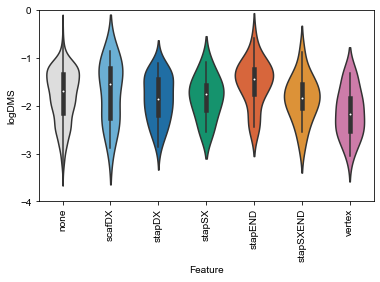

In [14]:
# Plot the distributions of DMS reactivities on each type of feature
fig, ax = plt.subplots()
origami_segment_bases["logDMS"] = np.log10(origami_segment_bases[dms_col])
origami_segment_bases["tidyFeature"] = origami_segment_bases[feat_col].apply(tidy_feature)
xlabels = ["none"] + feature_names
sns.violinplot(data=origami_segment_bases[np.isfinite(origami_segment_bases["logDMS"])], x="tidyFeature", y="logDMS",
               order=xlabels, inner="box", palette=tidy_colors)
ax.set_ylim(-4.0, 0.0)
ax.set_yticks(np.linspace(-4.0, 0.0, 5))
ax.set_aspect(1.0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90.0)
ax.set_xlabel("Feature")
plt.savefig("dms_by_feature.pdf")


<ipython-input-17-23febdf25846>:35: RuntimeWarning: divide by zero encountered in log10
  {"Position": pos_dn, "DMS": dms, "logDMS": np.log10(dms)})
<ipython-input-17-23febdf25846>:29: RuntimeWarning: divide by zero encountered in log10
  {"Position": pos_up, "DMS": dms, "logDMS": np.log10(dms)})


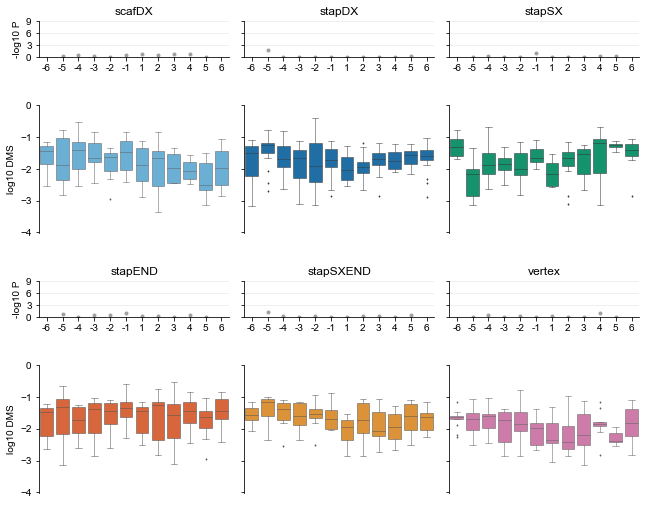

In [17]:
# Compute the mean DMS signal at each position upstream and downstream of each feature.
features_dms = dict()
features_dms_p = dict()
range_up = 6
range_dn = 6

for base in "M":
    features_dms[base] = dict()
    features_dms_p[base] = dict()
    for index in origami_segment_bases.index:
        origami, pos = index
        dms = origami_segment_bases.loc[index, dms_col]
        if np.isnan(dms):
            continue
        if base == "M" or base == origami_segment_bases.loc[index, base_col]:
            feat5 = tidy_feature(origami_segment_bases.loc[index, "Feature5"])
            feat3 = tidy_feature(origami_segment_bases.loc[index, "Feature3"])
            seg5 = origami_segment_bases.loc[index, "Seg5"]
            seg3 = origami_segment_bases.loc[index, "Seg3"]
            pos_up = pos - seg3 - 1  # position upstream from 3' feature
            assert pos_up <= -1
            pos_dn = pos - seg5 + 1  # position downstream from 5' feature
            assert pos_dn >= 1
            if pos_up >= -range_up:
                # add DMS signal to list at the position upstream of the 3' feature
                if feat3 not in features_dms[base]:
                    features_dms[base][feat3] = list()
                features_dms[base][feat3].append(
                    {"Position": pos_up, "DMS": dms, "logDMS": np.log10(dms)})
            if pos_dn <= range_dn:
                # add DMS signal to list at the position downstream of the 5' feature
                if feat5 not in features_dms[base]:
                    features_dms[base][feat5] = list()
                features_dms[base][feat5].append(
                    {"Position": pos_dn, "DMS": dms, "logDMS": np.log10(dms)})
    # convert each feature entry to a DataFrame
    for feat_i, feat in enumerate(feature_names):
        features_dms[base][feat] = pd.DataFrame.from_records(features_dms[base][feat])
    
    # compute p-values that medians on each side of the feature are equal
    for feat in feature_names:
        features_dms_p[base][feat] = dict()
        for p_pos in range(-range_up + 1, 0):
            dms_up = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] < p_pos]
            dms_pos = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] == p_pos]
            u, pval = mannwhitneyu(dms_pos, dms_up, alternative="greater")
            features_dms_p[base][feat][p_pos] = pval
        for p_pos in range(1, range_dn):
            dms_dn = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] > p_pos]
            dms_pos = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] == p_pos]
            u, pval = mannwhitneyu(dms_pos, dms_dn, alternative="greater")
            features_dms_p[base][feat][p_pos] = pval
        
    # box plot of logDMS reactivities and p-values
    nrows, ncols = 2, 3
    assert len(feature_names) == nrows * ncols
    fig, axs = plt.subplots(nrows=nrows*2, ncols=ncols, sharex=False, sharey=False)
    for feat_i, feat in enumerate(feature_names):
        i_row, i_col = divmod(feat_i, ncols)
        
        # logDMS reactivities
        ax_dms = axs[i_row * 2 + 1, i_col]
        sns.boxplot(data=features_dms[base][feat], x="Position", y="logDMS", ax=ax_dms,
                   linewidth=0.5, fliersize=1.0, color=tidy_colors[feat])
        ax_dms.set_ylim(-4.01, 0.0)
        ax_dms.set_xlabel("")
        ax_dms.set_yticks(np.linspace(-4.0, 0.0, 5))
        if i_col == 0:
            ax_dms.set_ylabel("log10 DMS")
        else:
            ax_dms.set_ylabel("")
            ax_dms.set_yticklabels([])
        ax_dms.spines["top"].set(visible=False)
        ax_dms.spines["bottom"].set(visible=False)
        ax_dms.spines["right"].set(visible=False)
        ax_dms.xaxis.tick_top()
        ax_dms.set_aspect(2.0)
        
        # logP-values
        ax_pvl = axs[i_row * 2, i_col]
        pos = np.array(list(features_dms_p[base][feat].keys()))
        neglogp = -np.log10(list(features_dms_p[base][feat].values()))
        p_pos = pos - pos[0] + (pos < 0)
        ax_pvl.scatter(p_pos, neglogp, c="#a0a0a0", s=9.0)
        ax_pvl.set_xticks(ax_dms.get_xticks())
        ax_pvl.set_xticklabels(np.hstack([[pos[0] - 1], pos, [pos[-1] + 1]]))
        ax_pvl.set_ylim(0.0, 9.1)
        if base == "M":
            ax_pvl.set_yticks(np.linspace(0.0, 9.0, 4))
        else:
            ax_pvl.set_yticks(np.linspace(0.0, 12.0, 5))
        if i_col == 0:
            ax_pvl.set_ylabel("-log10 P")
        else:
            ax_pvl.set_ylabel("")
            ax_pvl.set_yticklabels([])
        ax_pvl.spines["top"].set(visible=False)
        ax_pvl.spines["right"].set(visible=False)
        #ax_pvl.spines["bottom"].set(visible=False)
        ax_pvl.set_aspect(0.25)
        
        x_min = p_pos[0] - 1.5
        x_max = p_pos[-1] + 1.5
        ax_dms.set_xlim(x_min, x_max)
        ax_pvl.set_xlim(x_min, x_max)
        ax_dms.set_xticks([])
        #ax_dms.set_xticklabels([])
        ax_pvl.set_title(feat)
        
        # Add grid lines underneath the other plot elements (zorder=0)
        for y in ax_pvl.get_yticks()[1:]:
            ax_pvl.plot([x_min, x_max], [y, y], color="#e0e0e0", zorder=0, linewidth=0.5)
        #for y in ax_dms.get_yticks():
        #    ax_dms.plot([x_min, x_max], [y, y], color="#e8e8e8", zorder=0)
        
    fig.set_size_inches(ncols * 3.0, nrows * 3.8)
    plt.tight_layout()
    plt.savefig(f"features_dms_{base}.pdf")


In [18]:
# Compute the mean DMS signal and base composition at each position in each type of segment.
segments_dms = dict()
segments_base = dict()
for index in origami_segment_bases.index:
    origami, pos = index
    seg5 = origami_segment_bases.loc[index, "Seg5"]
    seg3 = origami_segment_bases.loc[index, "Seg3"]
    feat5 = origami_segment_bases.loc[index, "Feature5"]
    feat3 = origami_segment_bases.loc[index, "Feature3"]
    length = origami_segment_bases.loc[index, "Length"]
    dms = origami_segment_bases.loc[index, dms_col]
    base = origami_segment_bases.loc[index, base_col]
    seg = seg5, seg3
    feat = feat5, feat3
    if feat not in segments_dms:
        segments_dms[feat] = dict()
        segments_base[feat] = dict()
    if origami not in segments_dms[feat]:
        segments_dms[feat][origami] = dict()
        segments_base[feat][origami] = dict()
    if seg not in segments_dms[feat][origami]:
        segments_dms[feat][origami][seg] = dict()
        segments_base[feat][origami][seg] = dict()
    col = pos - seg5 + 1
    segments_dms[feat][origami][seg][col] = dms
    segments_base[feat][origami][seg][col] = base
for feat in segments_dms:
    feat_segs_dms = segments_dms[feat]
    feat_segs_base = segments_base[feat]
    for origami in feat_segs_dms:
        origami_segs_dms = feat_segs_dms[origami]
        origami_segs_base = feat_segs_base[origami]
        seg_lengths = list(map(len, origami_segs_dms.values()))
        seg_lengths_uniq = sorted(set(seg_lengths))
        max_len = max(seg_lengths_uniq)
        if len(seg_lengths_uniq) == 0:
            raise ValueError("empty set")
        elif len(seg_lengths_uniq) == 1:
            origami_segs_dms_adjust = origami_segs_dms
            origami_segs_base_adjust = origami_segs_base
        else:
            # Different segments with the same bordering features have different lengths.
            # Adjust the numbering so that everything is numbered as if it's the longest segment.
            origami_segs_dms_adjust = dict()
            origami_segs_base_adjust = dict()
            for seg in origami_segs_dms:
                seg_dms = origami_segs_dms[seg]
                seg_base = origami_segs_base[seg]
                seg_len = len(seg_dms)
                def adjust_col(col):
                    if col <= seg_len / 2:
                        return col
                    else:
                        return col + max_len - seg_len
                seg_dms_adjust = {adjust_col(col): dms for col, dms in seg_dms.items()}
                seg_base_adjust = {adjust_col(col): base for col, base in seg_base.items()}
                origami_segs_dms_adjust[seg] = seg_dms_adjust
                origami_segs_base_adjust[seg] = seg_base_adjust
        segments_dms[feat][origami] = pd.DataFrame.from_dict(origami_segs_dms_adjust, orient="index")
        segments_base[feat][origami] = pd.DataFrame.from_dict(origami_segs_base_adjust, orient="index")
        assert segments_dms[feat][origami].shape == segments_base[feat][origami].shape
        fname = f"segments_dms_{'-'.join(feat)}_{origami}.tsv"
        #segments_dms[feat][origami].to_csv(fname, sep="\t")
        fname = f"segments_base_{'-'.join(feat)}_{origami}.tsv"
        #segments_base[feat][origami].to_csv(fname, sep="\t")


/Users/mfa/mc/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mfa/mc/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mfa/mc/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mfa/mc/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mfa/mc/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


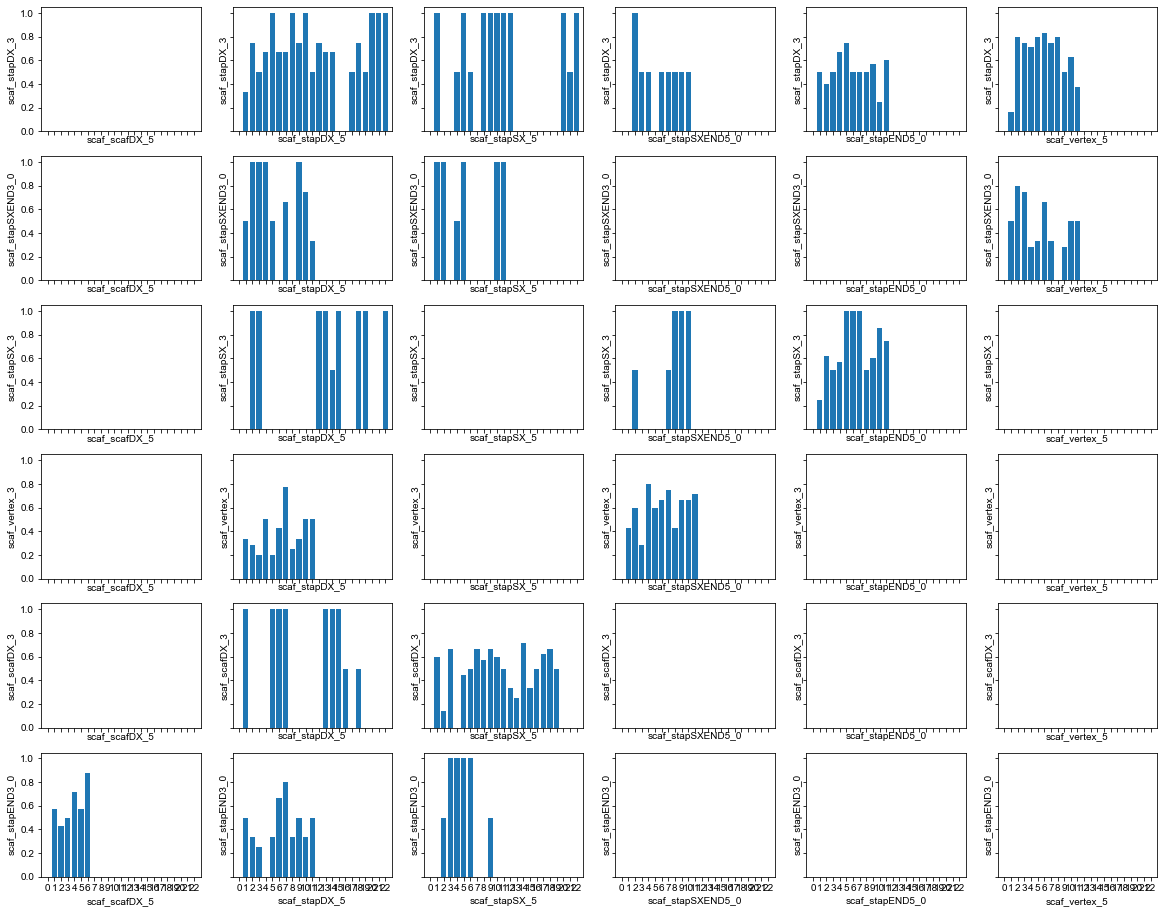

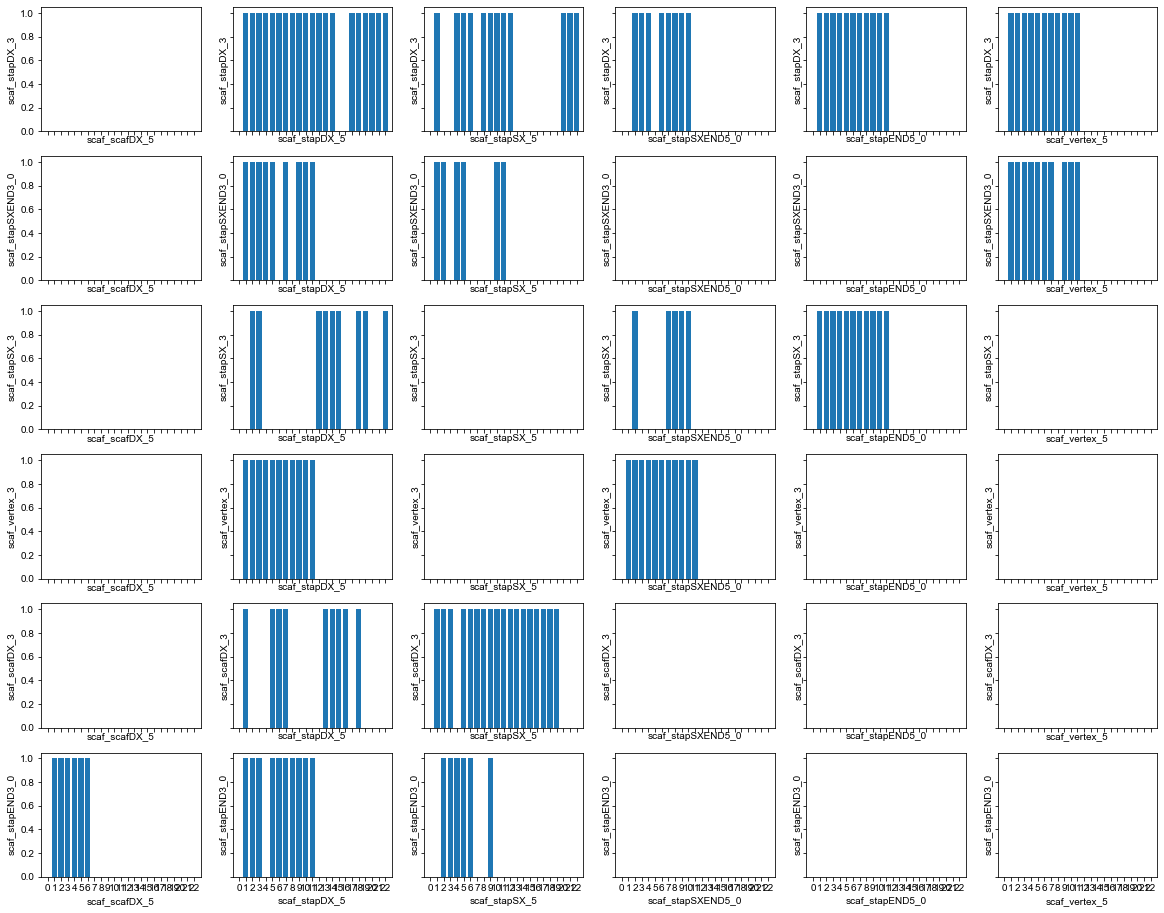

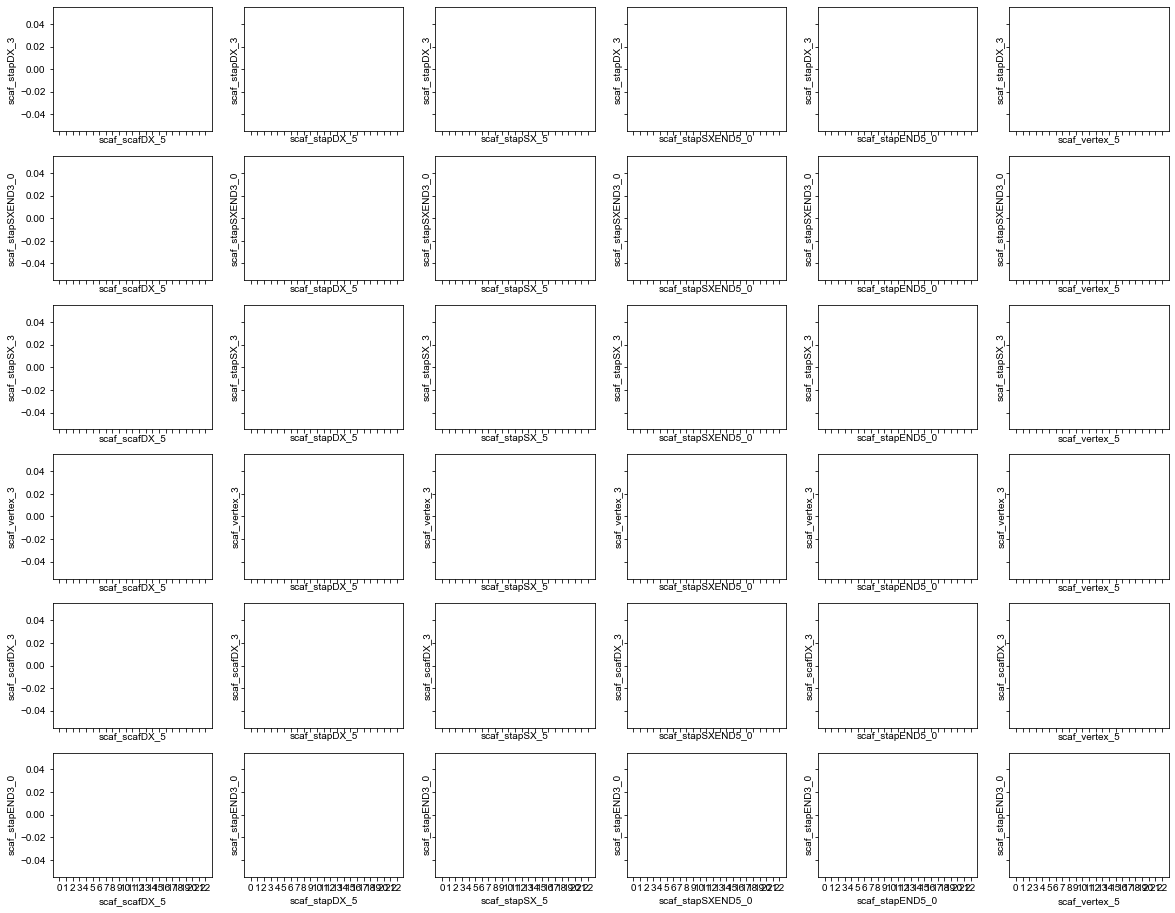

In [19]:
# Matrix of bar plots of DMS reactivities and A/C percentages.
max_len = 22
for base in "MAC":
    # DMS signal
    for log in [True, False]:
        fig, axs = plt.subplots(len(f5_vals), len(f3_vals), squeeze=False, sharex=True, sharey=True)
        for i5, feat5 in enumerate(f5_vals):
            for i3, feat3 in enumerate(f3_vals):
                feat = feat5, feat3
                ax = axs[i5, i3]
                if feat in segments_dms:
                    dms = pd.concat(list(segments_dms[feat].values()), axis=0)
                    if base in "AC":
                        bases = pd.concat(list(segments_base[feat].values()), axis=0)
                        dms = dms.where(bases == base)
                    if log:
                        dms = np.log10(dms)
                        value_name = "logDMS"
                    else:
                        value_name = "DMS"
                    longform = dms.melt(var_name="position", value_name=value_name)
                    sns.boxplot(data=longform, x="position", y=value_name, ax=ax, linewidth=0.25, fliersize=0.50)    
                ax.set_xticks(list(range(0, max_len + 1)))
                ax.set_xlim(-1, max_len + 1)
                ax.set_xlabel(feat3)
                ax.set_ylabel(feat5)
        fig.set_size_inches(20, 16)
        if log:
            fname = f"origami_segments_logdms_boxplot_{base}.pdf"
        else:
            fname = f"origami_segments_dms_boxplot_{base}.pdf"
        plt.savefig(fname)
        plt.close()
    # Percentage of A and C
    fig, axs = plt.subplots(len(f5_vals), len(f3_vals), squeeze=False, sharex=True, sharey=True)
    for i5, feat5 in enumerate(f5_vals):
        for i3, feat3 in enumerate(f3_vals):
            feat = feat5, feat3
            ax = axs[i5, i3]
            if feat in segments_dms:
                base_ids = pd.concat(list(segments_base[feat].values()), axis=0)
                if base in "AC":
                    bases = pd.concat(list(segments_base[feat].values()), axis=0)
                    base_ids = base_ids.where(bases == base)
                frac_A = base_ids.isin(["A"]).sum(axis=0) / base_ids.isin(["A", "C"]).sum(axis=0)
                value_name = "FracA"
                ax.bar(x=frac_A.index, height=frac_A)
            ax.set_xticks(list(range(0, max_len + 1)))
            ax.set_xlim(-1, max_len + 1)
            ax.set_xlabel(feat3)
            ax.set_ylabel(feat5)
    fig.set_size_inches(20, 16)
    fname = f"origami_segments_fracA_boxplot_{base}.pdf"
    plt.savefig(fname)

In [20]:
origami_segments = pd.concat(list(origami_segments.values()), axis=0, ignore_index=True)
origami_segments.to_csv("origami_segments.tsv", sep="\t")
origami_segments

,Seg5,Seg3,Feature5,Feature3,Origami,Length,DMS5M,DMS3M,DMS5aM,DMS3aM,...,DMSallA,DMSintA,DMS5C,DMS3C,DMS5aC,DMS3aC,DMSallC,DMSintC,GC,Tm
0,1,14,scaf_scafEND5_0,scaf_stapDX_5,rO66v1,14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.714286,61.445017
1,15,36,scaf_stapDX_3,scaf_stapDX_5,rO66v1,22,NaN,NaN,NaN,0.045364,...,0.028650,0.028650,NaN,NaN,NaN,NaN,0.014139,0.014139,0.500000,56.903398
2,37,47,scaf_stapDX_3,scaf_vertex_5,rO66v1,11,0.047625,0.002900,NaN,NaN,...,0.021975,0.021975,0.047625,0.002900,NaN,NaN,0.017536,0.039037,0.545455,31.006906
3,48,58,scaf_vertex_3,scaf_stapSXEND5_0,rO66v1,11,NaN,NaN,NaN,NaN,...,0.084500,0.084500,NaN,NaN,NaN,NaN,0.003437,0.003437,0.545455,35.043318
4,59,66,scaf_stapSX_3,scaf_stapEND5_0,rO66v1,8,NaN,0.016112,0.069827,0.067442,...,0.047618,0.068336,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,-2.539481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1533,1543,scaf_stapDX_3,scaf_stapEND5_0,rO66v1,11,NaN,0.095280,NaN,0.080985,...,0.061004,0.054569,NaN,NaN,NaN,NaN,0.035684,0.035684,0.363636,25.083639
131,1544,1554,scaf_stapEND3_0,scaf_stapDX_5,rO66v1,11,NaN,0.077135,0.002560,0.003024,...,0.089388,0.096226,NaN,NaN,0.002560,0.003024,0.002720,0.002720,0.545455,39.989903
132,1555,1565,scaf_stapDX_3,scaf_vertex_5,rO66v1,11,NaN,NaN,0.063892,0.028891,...,0.031398,0.031398,NaN,NaN,0.063892,NaN,0.038055,0.038055,0.363636,24.935210
133,1566,1576,scaf_vertex_3,scaf_stapSXEND5_0,rO66v1,11,0.006678,0.031203,0.005729,0.021583,...,0.029183,0.029183,0.006678,0.031203,NaN,0.021583,0.022987,0.036606,0.454545,27.298831


/Users/mfa/mc/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:979: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(d1._var / (d1.nobs - 1) + d2._var / (d2.nobs - 1))
/Users/mfa/mc/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:1006: RuntimeWarning: invalid value encountered in double_scalars
  sem1 = d1._var / (d1.nobs - 1)
/Users/mfa/mc/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/Users/mfa/mc/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:190: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
/Users/mfa/mc/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/mfa/mc/lib/python3.8/site-packages/pandas/core/arraylike.py:274: Runtime

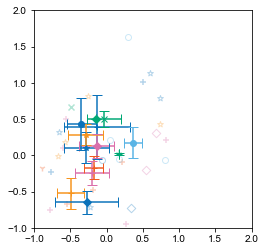

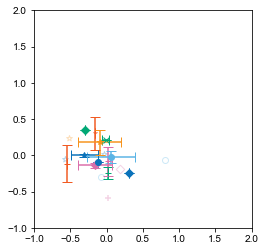

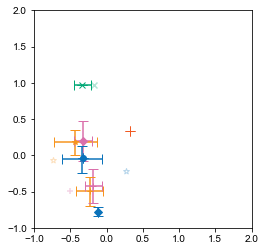

In [21]:
for base in "MAC":
    # For each segment class, determine the ratio of the ends to the interior
    seg_end_ratios = dict()
    fig, ax = plt.subplots()
    for feat5, feat3 in itertools.product(f5_vals, f3_vals):
        selector = np.logical_and(origami_segments["Feature5"] == feat5,
                                  origami_segments["Feature3"] == feat3)
        segs_feat = origami_segments.loc[selector]
        n_segs = segs_feat.shape[0]
        if n_segs > 0:
            # Confidence interval for ratio of ends to interior - unpaired
            log5 = np.log10(segs_feat[f"DMS5{base}"]).dropna()
            log3 = np.log10(segs_feat[f"DMS3{base}"]).dropna()
            log_int = np.log10(segs_feat[f"DMSint{base}"]).dropna()
            cm5 = sms.CompareMeans(sms.DescrStatsW(log5),
                                   sms.DescrStatsW(log_int))
            int5 = cm5.tconfint_diff(usevar="unequal")
            cm3 = sms.CompareMeans(sms.DescrStatsW(log3),
                                   sms.DescrStatsW(log_int))
            int3 = cm3.tconfint_diff(usevar="unequal")
            
            # Confidence interval for ratio of ends to interior - paired
            feat5_logratios = np.log10(segs_feat[f"DMS5{base}"] / segs_feat[f"DMSint{base}"])
            feat3_logratios = np.log10(segs_feat[f"DMS3{base}"] / segs_feat[f"DMSint{base}"])
            feat5_meanlog = np.mean(feat5_logratios)
            feat3_meanlog = np.mean(feat3_logratios)
            feat5_stdlog = np.std(feat5_logratios)
            feat3_stdlog = np.std(feat3_logratios)
            feat5_semlog = feat5_stdlog / np.sqrt(np.sum(np.logical_not(np.isnan(feat5_logratios))))
            feat3_semlog = feat3_stdlog / np.sqrt(np.sum(np.logical_not(np.isnan(feat3_logratios))))
            seg_end_ratios[feat5, feat3] = {"meanlog5": feat5_meanlog, "meanlog3": feat3_meanlog,
                                            "semlog5": feat5_semlog, "semlog3": feat3_semlog}
            marker, color, edgecolor = get_markers(feat5, feat3)
            ax.scatter(feat5_logratios, feat3_logratios,
                    marker=marker, c=color, edgecolor=edgecolor, alpha=0.3)
            ax.errorbar(feat5_meanlog, feat3_meanlog,
                    xerr=feat5_semlog, yerr=feat3_semlog,
                    marker=marker, c=colors3[feat3], alpha=1.0, capsize=5.0)
    ax.set_xlim((-1.0, 2.0))
    ax.set_ylim((-1.0, 2.0))
    ax.set_aspect(1.0)
    plt.savefig(f"seg_end_ratios_{base}.pdf")
    seg_end_ratios = pd.DataFrame.from_dict(seg_end_ratios, orient="index")
    seg_end_ratios.to_csv(f"seg_end_ratios_{base}.tsv", sep="\t")


/Users/mfa/mc/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/mfa/mc/lib/python3.8/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/mfa/mc/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/Users/mfa/mc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mfa/mc/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


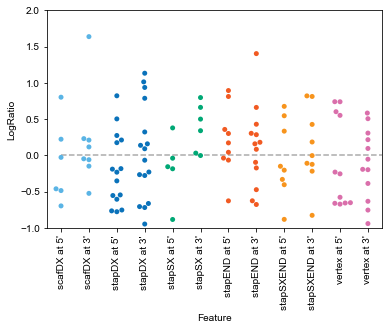

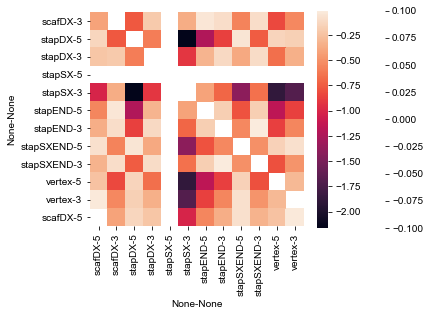

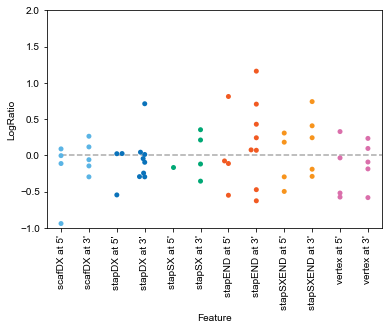

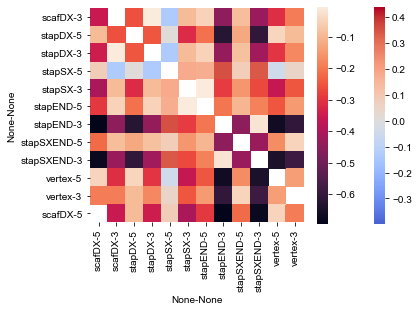

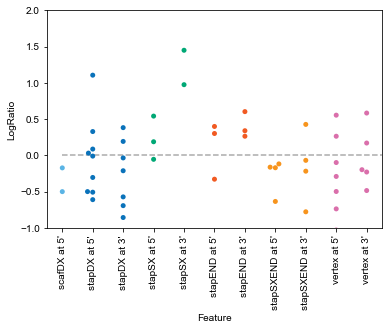

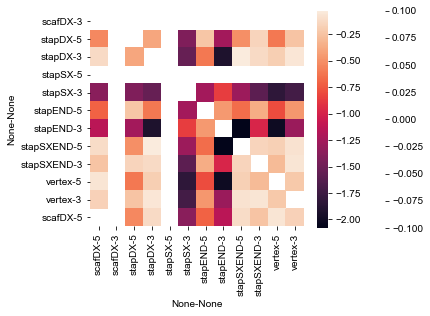

In [22]:
for base in "MAC":
    # For each feature, get all the segments involving the feature
    feat_logratios = dict()
    for feat in feature_names:
        feat5s = [f for f in markers5 if tidy_feature(f) == feat]
        assert len(feat5s) == 1
        feat5 = feat5s[0]
        feat3s = [f for f in colors3 if tidy_feature(f) == feat]
        assert len(feat3s) == 1
        feat3 = feat3s[0]
        interval = dict()
        for side, featside in {"5": feat5, "3": feat3}.items():
            selector = origami_segments[f"Feature{side}"] == featside
            segs_feat = origami_segments.loc[selector]
            n_segs = segs_feat.shape[0]
            if n_segs > 0:
                # Confidence interval for ratio of ends to interior - unpaired
                log_side = np.log10(segs_feat[f"DMS{side}{base}"]).dropna()
                log_int = np.log10(segs_feat[f"DMSint{base}"]).dropna()
                cm = sms.CompareMeans(sms.DescrStatsW(log_side),
                                      sms.DescrStatsW(log_int))
                interval[side] = cm.tconfint_diff(usevar="unequal")
                # Confidence interval for ratio of ends to interior - paired
                feat_logratios[feat, side] = np.log10(segs_feat[f"DMS{side}{base}"] / segs_feat[f"DMSint{base}"]).dropna()
    feat_logratios_df = pd.DataFrame.from_dict(dict(enumerate([{"Feature": f"{feat} at {side}'", "LogRatio": logratio}
            for (feat, side), logratios in feat_logratios.items() for logratio in logratios])), orient="index")
    feat_logratios_df.to_csv(f"feature_logratios_{base}.tsv", sep="\t")
    fig, ax = plt.subplots()
    palette = {feat: get_feature_hex(feat.split()[0])
               for feat in set(list(feat_logratios_df["Feature"]))}
    sns.swarmplot(data=feat_logratios_df, x="Feature", y="LogRatio", palette=palette)
    xlabels = ax.get_xticklabels()
    #for xlabel in xlabels:
    
    ax.plot([0, len(xlabels)], [0.0, 0.0], c="#aaaaaa", linestyle="--")
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_ylim(-1.0, 2.0)
    plt.savefig(f"feature_logratios_{base}.pdf")
    # P-value matrix
    fig, ax = plt.subplots()
    feature_diffs = defaultdict(dict)
    feature_pvals = defaultdict(dict)
    for f1, f2 in itertools.combinations(feat_logratios, 2):
        lr1 = feat_logratios[f1]
        lr2 = feat_logratios[f2]
        result = ttest_ind(lr1, lr2, equal_var=False)
        diff_mean = np.mean(lr2) - np.mean(lr1)
        pval = result.pvalue
        feature_diffs[f1][f2] = diff_mean
        feature_diffs[f2][f1] = diff_mean
        feature_pvals[f1][f2] = pval
        feature_pvals[f2][f1] = pval
    feature_diffs = pd.DataFrame.from_dict(feature_diffs)
    feature_pvals = pd.DataFrame.from_dict(feature_pvals)
    sns.heatmap(feature_diffs, square=True, center=0.0, cmap="coolwarm")
    plt.savefig(f"feature_diffs_{base}.pdf")
    sns.heatmap(np.log10(feature_pvals), square=True)
    plt.savefig(f"feature_logpvals_{base}.pdf")

In [23]:
feat_logratios

{('scafDX',
  '5'): 41    -0.173264
 124   -0.501018
 dtype: float64,
 ('scafDX', '3'): Series([], dtype: float64),
 ('stapDX',
  '5'): 2      0.086356
 9      0.030545
 14    -0.508638
 21     0.328013
 27     1.105917
 90    -0.305464
 103   -0.611558
 121   -0.500538
 126   -0.010665
 dtype: float64,
 ('stapDX',
  '3'): 20    -0.212869
 35    -0.858077
 44     0.381956
 72     0.191750
 111   -0.694235
 120   -0.573536
 129   -0.035846
 dtype: float64,
 ('stapSX',
  '5'): 32         -inf
 38     0.541127
 78     0.187232
 108   -1.383287
 134   -0.055172
 dtype: float64,
 ('stapSX',
  '3'): 24    1.449407
 41    0.974598
 dtype: float64,
 ('stapEND',
  '5'): 5     0.301030
 17    0.398256
 55   -0.329324
 dtype: float64,
 ('stapEND',
  '3'): 73     0.339379
 115    0.263568
 128    0.602936
 dtype: float64,
 ('stapSXEND',
  '5'): 19    -0.171292
 29    -0.163422
 101   -0.636323
 125   -0.118396
 dtype: float64,
 ('stapSXEND',
  '3'): 31    -0.779250
 91     0.426615
 107   -0.21869

Length vs GC
	PCC: (0.023970798257989073, 0.782574744916058)
	SRC: SpearmanrResult(correlation=0.07502242743020222, pvalue=0.38715094149107443)
Length vs Tm
	PCC: (0.772091689403972, 5.817790564221824e-28)
	SRC: SpearmanrResult(correlation=0.8344400192760586, pvalue=3.161741014678369e-36)
Length vs DMSintM
	PCC: (-0.2497167039981423, 0.003881534787215778)
	SRC: SpearmanrResult(correlation=-0.2183546988396363, pvalue=0.011894049844990063)
GC vs Tm
	PCC: (0.5167971971922668, 1.3923252260690804e-10)
	SRC: SpearmanrResult(correlation=0.4995115680967915, pvalue=6.947420075810595e-10)
GC vs DMSintM
	PCC: (-0.2651088256469906, 0.0021258543558795467)
	SRC: SpearmanrResult(correlation=-0.3214014738608606, pvalue=0.00017147990860241077)
Tm vs DMSintM
	PCC: (-0.3461984395061872, 4.7794406631172504e-05)
	SRC: SpearmanrResult(correlation=-0.3333315940788821, pvalue=9.400609111598118e-05)
Length vs GC
	PCC: (0.023970798257989073, 0.782574744916058)
	SRC: SpearmanrResult(correlation=0.075022427430202

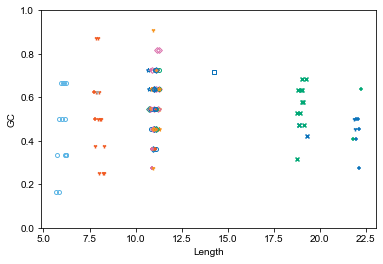

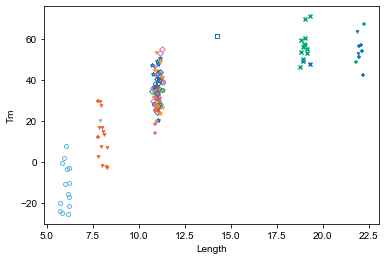

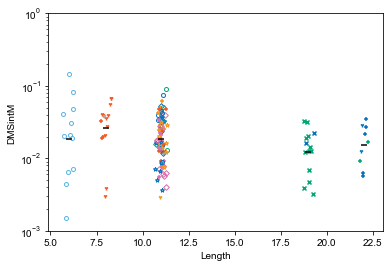

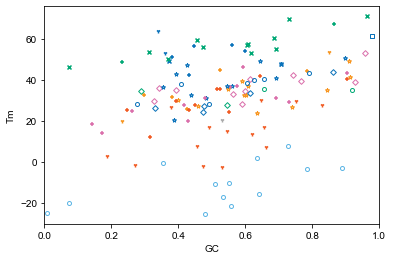

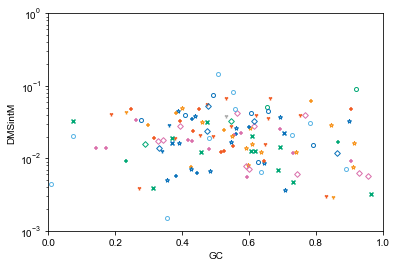

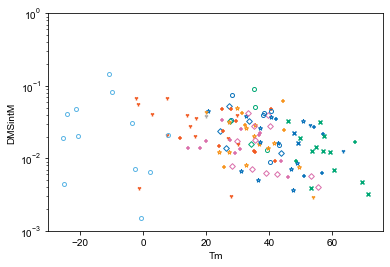

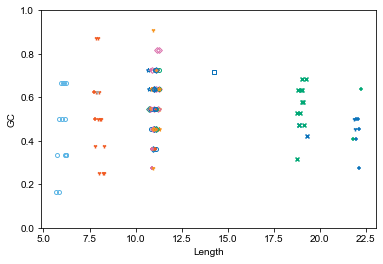

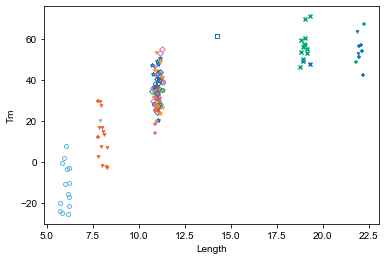

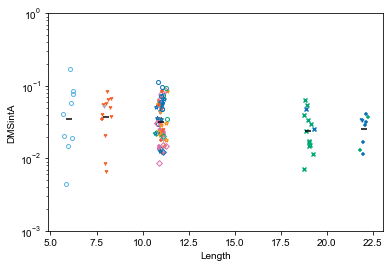

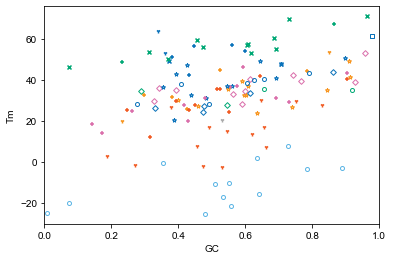

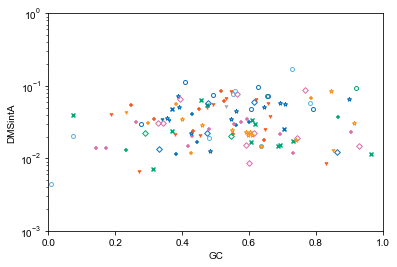

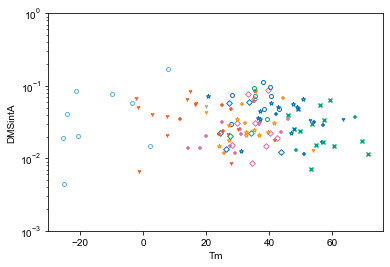

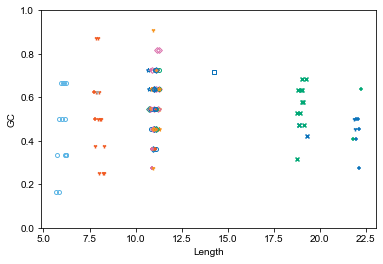

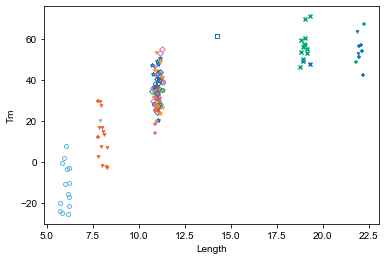

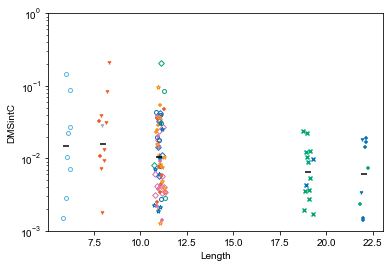

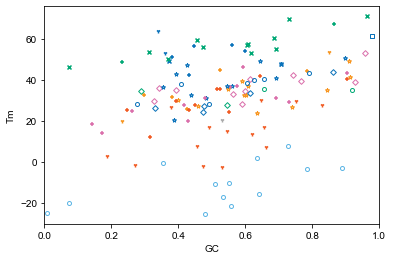

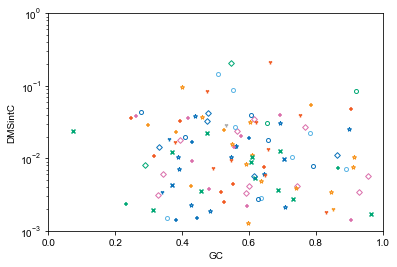

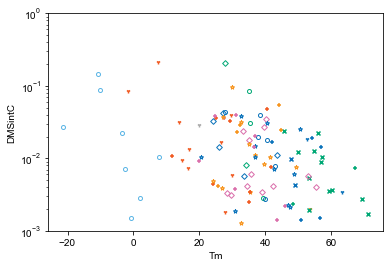

In [24]:
for base in "MAC":
    # Plots of two variables at a time
    for p1, p2 in itertools.combinations(
        ["Length", "GC", "Tm", f"DMSint{base}"], 2):
        np.random.seed(0)
        labels = set()
        fig, ax = plt.subplots()
        xs = list()
        ys = list()
        for seg in origami_segments.index:
            x = origami_segments.loc[seg, p1]
            y = origami_segments.loc[seg, p2]
            xs.append(x)
            ys.append(y)
            x_jitter = np.random.randn() * jitter_std
            if x_jitter > 0:
                x_jitter = min(x_jitter, jitter_max)
            else:
                x_jitter = max(x_jitter, -jitter_max)
            if "DMS" in p1:
                ax.set_xscale("log")
            if "DMS" in p2:
                ax.set_yscale("log")
            label = None
            f5 = origami_segments.loc[seg, "Feature5"]
            f3 = origami_segments.loc[seg, "Feature3"]
            marker, color, edgecolor = get_markers(f5, f3)
            ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)
        # add means
        lengths = sorted(set(origami_segments["Length"]))
        if p1 == "Length" and "DMS" in p2:
            seg_length_dms_means = pd.Series({length: np.log10(origami_segments.loc[
                origami_segments["Length"] == length, p2]).mean()
                for length in lengths})
            y = np.power(10.0, seg_length_dms_means)
            ax.scatter(y.index, y, c="black", marker="_")
        ax.set_xlabel(p1)
        ax.set_ylabel(p2)
        xs = np.asarray(xs)
        ys = np.asarray(ys)
        use = [not (np.isnan(x) or np.isnan(y)) for x, y in zip(xs, ys)]
        r = pearsonr(xs[use], ys[use])
        rho = spearmanr(xs[use], ys[use])
        print(p1, "vs", p2)
        print("\tPCC:", r)
        print("\tSRC:", rho)
        if p1 == "GC":
            ax.set_xlim((0.0, 1.0))
        elif p1 == "length":
            ax.set_xlim((6, 24))
            ax.set_xticks(list(range(6, 24 + 1, 2)))
        if p2 == "GC":
            ax.set_ylim((0.0, 1.0))
        elif "DMS" in p2:
            ax.set_ylim((1e-3, 1e0))
        #plt.legend()
        plt.savefig(f"segment_data_{p1}_{p2}.pdf")
